In [15]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
import captum
from captum.attr import (
    IntegratedGradients,
    Occlusion,
    LayerGradCam,
    LayerAttribution,
    NoiseTunnel,
)
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

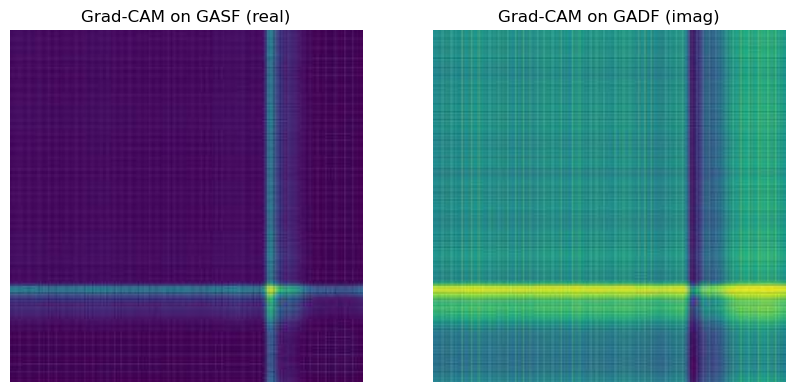

In [16]:
gasf_image = Image.open(
    "/home/prasad/Desktop/datas2/GASFC_train_test_val/val/data_22_13/sample1_segment12_label1.jpeg"
).convert("RGB")
test_real_data = np.asarray(gasf_image)


gadf_image = Image.open(
    "/home/prasad/Desktop/datas2/GADFC_train_test_val/val/data_22_13/sample1_segment12_label1.jpeg"
).convert("RGB")
test_img_data = np.asarray(gadf_image)


# Show with matplotlib
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_real_data)
plt.title("Grad-CAM on GASF (real)")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(test_img_data)
plt.title("Grad-CAM on GADF (imag)")
plt.axis("off")
plt.show()

In [17]:
transforms_gadf = transforms.Compose(
    [
        transforms.Normalize(
            mean=[0.19756491, 0.5550784, 0.50753045],
            std=[0.08108524, 0.10870767, 0.05927933],
        ),
    ]
)
transforms_gasf = transforms.Compose(
    [
        transforms.Normalize(
            mean=[0.25332475, 0.17397244, 0.43626496],
            std=[0.03306787, 0.08601908, 0.04909801],
        ),
    ]
)
transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)
gadf = transforms(gadf_image)
gasf = transforms(gasf_image)

transformed_gadf_image = transforms_gadf(gadf)
transformed_gasf_image = transforms_gasf(gasf)

complex_r = torch.complex(transformed_gasf_image[0], transformed_gadf_image[0])
complex_g = torch.complex(transformed_gasf_image[1], transformed_gadf_image[1])
complex_b = torch.complex(transformed_gasf_image[2], transformed_gadf_image[2])

# Stack channels to form the final complex image
complex_image = torch.stack([complex_r, complex_g, complex_b], dim=0)
label = torch.tensor([1])

In [18]:
from models.complex_resnet import complex_resnet18


class ComplexResNetCAM(torch.nn.Module):
    def __init__(self, config, checkpoint_path, device):
        super().__init__()
        self.model = complex_resnet18(config)
        state = torch.load(checkpoint_path, map_location=device)
        new_state = {
            k[7:] if k.startswith("module.") else k: v for k, v in state.items()
        }
        self.model.load_state_dict(new_state, strict=True)
        self.model.to(device).eval()

        # We want to hook the *module*, not a tensor
        target = self.model.layer4[-1].conv2  # the ComplexConv2d layer
        self.gradients = None

        # forward hook to save the activation
        def forward_hook(module, inp, out):
            # out is complex; we'll store it for later
            self.activations = out

        # backward hook to save grad of that activation
        def backward_hook(module, grad_in, grad_out):
            # grad_out[0] is dL/d(out)
            self.gradients = grad_out[0]

        target.register_forward_hook(forward_hook)
        target.register_full_backward_hook(backward_hook)

    def forward(self, x):
        # pre‐process to complex
        if not torch.is_complex(x):
            real, imag = x[:, :3], x[:, 3:]
            x = torch.complex(real, imag)

        # run entire model straight through
        return self.model(x)

    def get_activations(self):
        return self.activations

    def get_activations_gradient(self):
        return self.gradients

In [22]:
from data.dataloader import load_config


config = load_config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = "saved_models/Complex_Resnet18_GASF_iGADF/Complex_Resnet18_GASF_iGADF_model_epoch_29.pth"

# 1) Build and load
cam_model = ComplexResNetCAM(config, checkpoint, device)

# 2) Prepare input
complex_img = complex_image.unsqueeze(0).to(device)
inp = torch.cat([complex_img.real, complex_img.imag], dim=1)
inp.requires_grad_()

# 3) Forward + backward
cam_model.zero_grad()
logit = cam_model(inp)  # forward through full model
logit[0, 0].backward()  # backward from the single logit
pred = torch.sigmoid(logit) > 0.5
print("Prediction:", pred.item())
# 4) Retrieve
grads = cam_model.get_activations_gradient()  # will be a complex tensor gradient
acts = cam_model.get_activations()  # the complex activations

print("Gradients:", grads.shape, grads.dtype)
print("Activations:", acts.shape, acts.dtype)
real_grads = grads.real
imag_grads = grads.imag
real_acts = acts.real
imag_acts = acts.imag


Creating complex ResNet-18 with 3 complex channels and 1 classes
Prediction: True
Gradients: torch.Size([1, 512, 7, 7]) torch.complex64
Activations: torch.Size([1, 512, 7, 7]) torch.complex64


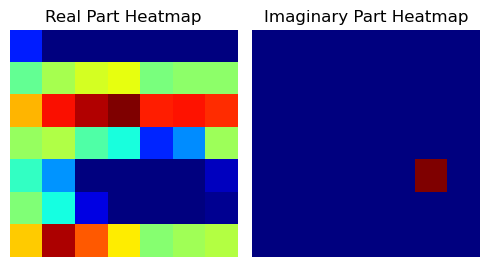

In [20]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2


def compute_gradcam_heatmap(activations, gradients):
    """
    activations: Tensor of shape [1, C, h, w]
    gradients:   Tensor of shape [1, C, h, w]
    returns:     heatmap np.ndarray of shape [h, w] in [0,1]
    """
    # 1) Pool gradients across spatial dims → [C]
    pooled = gradients.mean(dim=[0, 2, 3])  # shape [C]

    # 2) Weight channels
    weighted = activations.clone()
    for i in range(weighted.shape[1]):
        weighted[:, i, :, :] *= pooled[i]

    # 3) Average across channels → [1, h, w]
    heatmap = weighted.mean(
        dim=1, keepdim=True
    )  # [1,1,h,w] if keepdim, but here [1,h,w]
    heatmap = F.relu(heatmap)  # only positives
    heatmap = heatmap.squeeze().cpu().detach().numpy()

    # 4) Normalize to [0,1]
    heatmap = np.maximum(heatmap, 0)
    if heatmap.max() > 0:
        heatmap /= heatmap.max()
    return heatmap

# Compute two heatmaps
heatmap_real = compute_gradcam_heatmap(real_acts, real_grads)
heatmap_imag = compute_gradcam_heatmap(imag_acts, imag_grads)

# Show the heatmaps
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(heatmap_real, cmap='jet')
plt.title('Real Part Heatmap')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(heatmap_imag, cmap='jet')
plt.title('Imaginary Part Heatmap')
plt.axis('off')
plt.tight_layout()
plt.show()



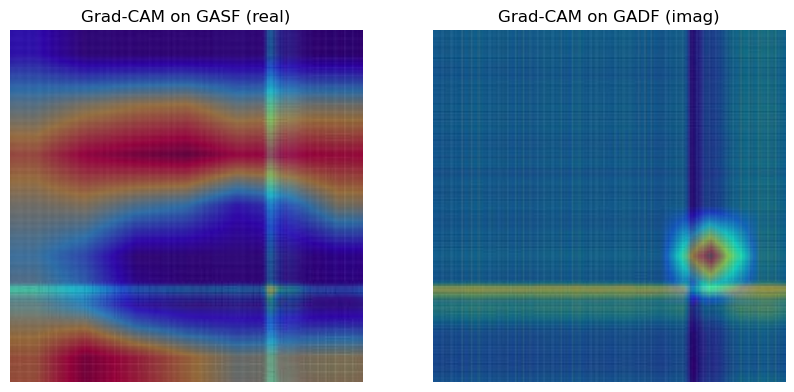

In [21]:
# Resize & overlay function
def overlay_on_original(
    original_image, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET
):
    """
    original_complex:  Tensor [1,3,H,W] complex
    heatmap:           np.ndarray [h,w] normalized [0,1]
    returns:           BGR overlay np.ndarray [H,W,3]
    """
    bg = original_image.cpu().numpy().transpose(1, 2, 0)  # [H,W,3] in RGB
    bg = cv2.cvtColor(bg, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV

    # Normalize to [0,255]
    bg = (255 * (bg - bg.min()) / (bg.max() - bg.min() + 1e-8)).astype(np.uint8)

    H, W = bg.shape[:2]
    hm_resized = cv2.resize(heatmap, (W, H))
    hm_uint8 = np.uint8(255 * hm_resized)
    hm_color = cv2.applyColorMap(hm_uint8, colormap)
    overlay = cv2.addWeighted(hm_color, alpha, bg, 1 - alpha, 0)
    return overlay


# Prepare your original GAF images:
# complex_img: [1,3,H,W] complex (GASF in real, GADF in imag)
overlay_real = overlay_on_original(gasf, heatmap_real)
overlay_imag = overlay_on_original(gadf, heatmap_imag)

# Show with matplotlib (convert BGR to RGB)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(overlay_real, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM on GASF (real)")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(overlay_imag, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM on GADF (imag)")
plt.axis("off")
plt.show()